<a href="https://colab.research.google.com/github/AbdenourCh/CNN-CIFAR10/blob/main/CIFAR10_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import numpy as np

In [3]:
train_on_gpu = torch.cuda.is_available()

if train_on_gpu :
  print("CUDA available, Training on GPU ...")
else:
  print("CUDA not available, Training on CPU ...")

CUDA available, Training on GPU ...


In [4]:
from torchvision import datasets
from torchvision.transforms import transforms
from torch.utils.data.sampler import SubsetRandomSampler


num_workers = 0
batch_size = 20
valid_size = 0.2

transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(10),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])
                               
train_data = datasets.CIFAR10('data', train=True,
                                   download=True, transform=transform)
test_data = datasets.CIFAR10('data/', train=False,
                                  download=True, transform=transform)

num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)


train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


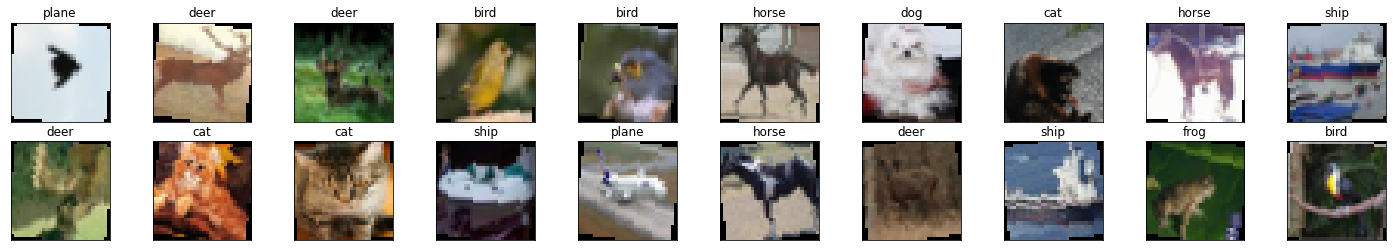

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline


def imshow(img):
  img = img / 2 + 0.5
  plt.imshow(np.transpose(img, (1,2,0)))

    
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()


fig = plt.figure(figsize=(25,4))


for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [6]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 128, 3, padding=1)
        self.conv2 = nn.Conv2d(128,256, 3, padding=1)
        self.conv3 = nn.Conv2d(256, 512, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(512 * 4 * 4, 500)
        self.fc2 = nn.Linear(500, 500)
        self.fc3 = nn.Linear(500, 500)
        self.fc4 = nn.Linear(500, 10)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        x = x.view(-1, 512 * 4 * 4)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return x

model = Net()
print(model)

if train_on_gpu:
    model.cuda()

Net(
  (conv1): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=8192, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=500, bias=True)
  (fc3): Linear(in_features=500, out_features=500, bias=True)
  (fc4): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [9]:
n_epochs = 30

valid_loss_min = np.Inf 
for epoch in range(1, n_epochs+1):

    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for batch_idx, (data, target) in enumerate(valid_loader):
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        output = model(data)
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)
    
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
        
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_augmented.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 2.286196 	Validation Loss: 2.122607
Validation loss decreased (inf --> 2.122607).  Saving model ...
Epoch: 2 	Training Loss: 1.924600 	Validation Loss: 1.659066
Validation loss decreased (2.122607 --> 1.659066).  Saving model ...
Epoch: 3 	Training Loss: 1.617678 	Validation Loss: 1.440165
Validation loss decreased (1.659066 --> 1.440165).  Saving model ...
Epoch: 4 	Training Loss: 1.443354 	Validation Loss: 1.332745
Validation loss decreased (1.440165 --> 1.332745).  Saving model ...
Epoch: 5 	Training Loss: 1.321530 	Validation Loss: 1.212387
Validation loss decreased (1.332745 --> 1.212387).  Saving model ...
Epoch: 6 	Training Loss: 1.213686 	Validation Loss: 1.099424
Validation loss decreased (1.212387 --> 1.099424).  Saving model ...
Epoch: 7 	Training Loss: 1.114571 	Validation Loss: 1.050555
Validation loss decreased (1.099424 --> 1.050555).  Saving model ...
Epoch: 8 	Training Loss: 1.034928 	Validation Loss: 0.993208
Validation loss decreased (1.05055

In [10]:
model.load_state_dict(torch.load('model_augmented.pt'))

<All keys matched successfully>

In [11]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
for batch_idx, (data, target) in enumerate(test_loader):
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.579095

Test Accuracy of plane: 83% (838/1000)
Test Accuracy of   car: 89% (899/1000)
Test Accuracy of  bird: 74% (744/1000)
Test Accuracy of   cat: 60% (609/1000)
Test Accuracy of  deer: 82% (824/1000)
Test Accuracy of   dog: 74% (748/1000)
Test Accuracy of  frog: 81% (819/1000)
Test Accuracy of horse: 87% (873/1000)
Test Accuracy of  ship: 85% (853/1000)
Test Accuracy of truck: 88% (883/1000)

Test Accuracy (Overall): 80% (8090/10000)


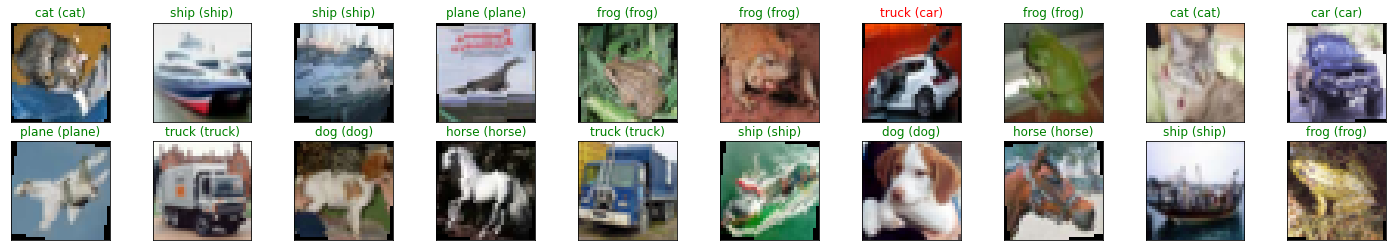

In [12]:
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

if train_on_gpu:
    images = images.cuda()


output = model(images)

_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

images = images.cpu()



fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))